In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast,AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from datetime import date, datetime, time
from babel.dates import format_time
from tqdm import tqdm

In [44]:
dataset="diffQ_Suffix.csv"
save_pt='saved_weights.pt'
device_name='cuda'
learning_rate=1e-5
batch_size=32
epochs = 10


In [45]:
device = torch.device(device_name)

In [46]:
df = pd.read_csv(dataset)
df.head()
df['label'].value_counts(normalize = True)

label
True     0.58898
False    0.41102
Name: proportion, dtype: float64

In [47]:
df['label']=df['label'].map(lambda x:0 if x==True else 1)

In [48]:
df['label']

0        0
1        0
2        0
3        0
4        0
        ..
67909    1
67910    1
67911    1
67912    1
67913    1
Name: label, Length: 67914, dtype: int64

In [49]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['prompt'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [50]:
bert = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

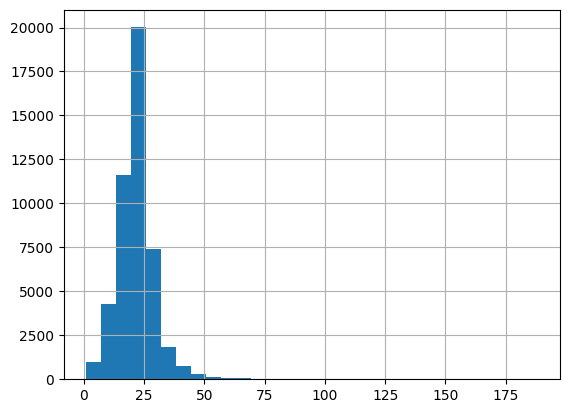

In [51]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [52]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)



c:\Users\zihui\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [53]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [54]:


# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [55]:
for param in bert.parameters():
    param.requires_grad = False

In [56]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [57]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
optimizer = AdamW(model.parameters(),lr = learning_rate) 

c:\Users\zihui\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [58]:
class_weights = compute_class_weight(class_weight='balanced', classes =np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.84891071 1.21651569]


In [59]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 



In [60]:
def train(i):
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    loop=tqdm(enumerate(train_dataloader),total=len(train_dataloader),leave=True)
    for step,batch in loop:
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        loop.set_description(f'Epoch [{i}/{epochs+1}]')
        loop.set_postfix(loss = loss)

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [61]:
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    loop1=tqdm(enumerate(val_dataloader),total=len(val_dataloader),leave=True)
    for step,batch in loop1:
        

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)
          # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)
        
        loop1.set_postfix(loss = loss)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [62]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs): 
    
    #train model
    train_loss, _ = train(epoch)
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

Epoch [0/11]: 100%|██████████| 1486/1486 [01:26<00:00, 17.25it/s, loss=tensor(0.2618, device='cuda:0', grad_fn=<NllLossBackward0>)]



Evaluating...


 16%|█▋        | 52/319 [00:02<00:13, 19.41it/s, loss=tensor(0.1360, device='cuda:0')]

  Batch    50  of    319.


 32%|███▏      | 103/319 [00:05<00:10, 19.87it/s, loss=tensor(0.1089, device='cuda:0')]

  Batch   100  of    319.


 48%|████▊     | 153/319 [00:08<00:08, 19.79it/s, loss=tensor(0.1156, device='cuda:0')]

  Batch   150  of    319.


 64%|██████▎   | 203/319 [00:10<00:05, 19.40it/s, loss=tensor(0.1163, device='cuda:0')]

  Batch   200  of    319.


 79%|███████▉  | 253/319 [00:13<00:03, 19.68it/s, loss=tensor(0.1178, device='cuda:0')]

  Batch   250  of    319.


 95%|█████████▍| 302/319 [00:15<00:00, 19.75it/s, loss=tensor(0.1380, device='cuda:0')]

  Batch   300  of    319.


100%|██████████| 319/319 [00:16<00:00, 19.25it/s, loss=tensor(0.1071, device='cuda:0')]



Training Loss: 0.343
Validation Loss: 0.136


Epoch [1/11]:  13%|█▎        | 197/1486 [00:11<01:13, 17.55it/s, loss=tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward0>)]

In [ ]:
from sklearn.metrics import classification_report

#load weights of best model
path = save_pt
model.load_state_dict(torch.load(path))
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))